In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.train.train import ContrastiveLoss
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
READ = False

In [3]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [4]:
MODEL = 'v8.0'
MODELS_DESCRIPTION = {
    'nesymres-100M': 'NeSymReS 100M',
    'pysr': 'PySR',
}

if MODEL not in MODELS_DESCRIPTION:
    MODELS_DESCRIPTION[MODEL] = MODEL

In [5]:
space = ExpressionSpace.from_config(get_path('configs', MODEL, 'expression_space.yaml'))

In [6]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool-15',
}
TEST_SET_TITLES_LONG = {
    'train': 'Train',
    'val': 'Validation',
    'feynman': 'Feynman',
    'soose_nc': 'SOOSE-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool-15',
}

In [7]:
configs = {}

with open(get_path(f'configs/{MODEL}/evaluation.yaml'), 'r') as f:
    configs[MODEL] = yaml.safe_load(f)

In [8]:
test_sets = {MODEL: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{MODEL}'))]}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [9]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [10]:
remove_invalid = []

for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Loading {model} results'):
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            # keys_to_remove.extend(['x', 'y'])

            for k in keys_to_remove:
                del test_set_results['data'][k]

Loading v8.0 results: 100%|██████████| 6/6 [02:02<00:00, 20.36s/it]


In [11]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
            results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))

100%|██████████| 6/6 [00:00<00:00, 3158.76it/s]


In [12]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']
        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])
        results[model][test_set]['data']['n_constants_target'] = np.array([sum(1 for token in data['input_ids'][i] if token == space.tokenizer['<num>']) for i in range(len(data['input_ids']))])
        results[model][test_set]['data']['n_unique_variables_target'] = np.array([len(np.unique([token for token in data['input_ids'][i] if space.tokenizer[int(token)] in space.variables])) for i in range(len(data['input_ids']))])

        for j in range(beam_width):
            if f'free_beam_{j + 1}' in data:
                results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])
            if f'residuals_beam_{j + 1}' in data:
                results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

        for j in range(beam_width):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)


100%|██████████| 6/6 [00:00<00:00, 20.82it/s]


In [13]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


In [14]:
def max_span(x):
    x = x.reshape(-1, x.shape[-1])
    nonzero_columns = (x != 0).any(0)
    if np.all(~nonzero_columns):
        return 0
    return (x[:, nonzero_columns].max(0) - x[:, nonzero_columns].min(0)).max()

def min_span(x):
    x = x.reshape(-1, x.shape[-1])
    nonzero_columns = (x != 0).any(0)
    if np.all(~nonzero_columns):
        return 0
    return (x[:, nonzero_columns].max(0) - x[:, nonzero_columns].min(0)).min()

# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        test_set_results['data']['is_finite'] = np.array([np.isfinite(r2) for r2 in test_set_results['data']['r2_best_beam']])

        test_set_results['data']['FVU-eps_accuracy'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data']['r2_best_beam']])

        test_set_results['data']['fvu'] = np.array([1 - r2 for r2 in test_set_results['data']['r2_best_beam']])
        test_set_results['data']['log_fvu'] = np.array([np.log10(max(1 - r2, np.finfo(np.float32).eps)) for r2 in test_set_results['data']['r2_best_beam']])

        test_set_results['data']['fvu_not_epsilon'] = np.copy(test_set_results['data']['fvu'])
        test_set_results['data']['fvu_not_epsilon'][test_set_results['data']['FVU-eps_accuracy']] = np.nan

        test_set_results['data']['log_fvu_not_epsilon'] = np.array([np.log10(fvu) for fvu in test_set_results['data']['fvu_not_epsilon']])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = np.array([np.log10(ppl) for ppl in test_set_results['data']['perplexity']])
        else:
            test_set_results['data']['log_ppl'] = np.array([np.nan] * len(test_set_results['data']['r2_best_beam']))
            
        test_set_results['data']['n_constants_pred'] = np.array([sum(
            1 for token in data[f'free_beam_{int(b)}'][i] if token == space.tokenizer['<num>']) if not np.isnan(b) else np.nan for i, b in enumerate(test_set_results['data']['best_beam'])
        ])
        
        results[model][test_set]['data']['n_unique_variables_pred'] = np.array([len(np.unique([token for token in data[f'free_beam_{int(b)}'][i] if space.tokenizer[int(token)] in space.variables])) if not np.isnan(b) else np.nan for i, b in enumerate(test_set_results['data']['best_beam'])])

        results[model][test_set]['data']['length_pred'] = np.array([len(data[f'free_beam_{int(b)}'][i]) if not np.isnan(b) else np.nan for i, b in enumerate(test_set_results['data']['best_beam'])])

        results[model][test_set]['data']['x_max_span'] = np.array([max_span(data['x'][i]) for i in range(len(data['x']))])
        results[model][test_set]['data']['x_min_span'] = np.array([min_span(data['x'][i]) for i in range(len(data['x']))])

        results[model][test_set]['data']['length_diff'] = results[model][test_set]['data']['length_pred'] - results[model][test_set]['data']['length_target']

# GT vs Pred Equation Properties

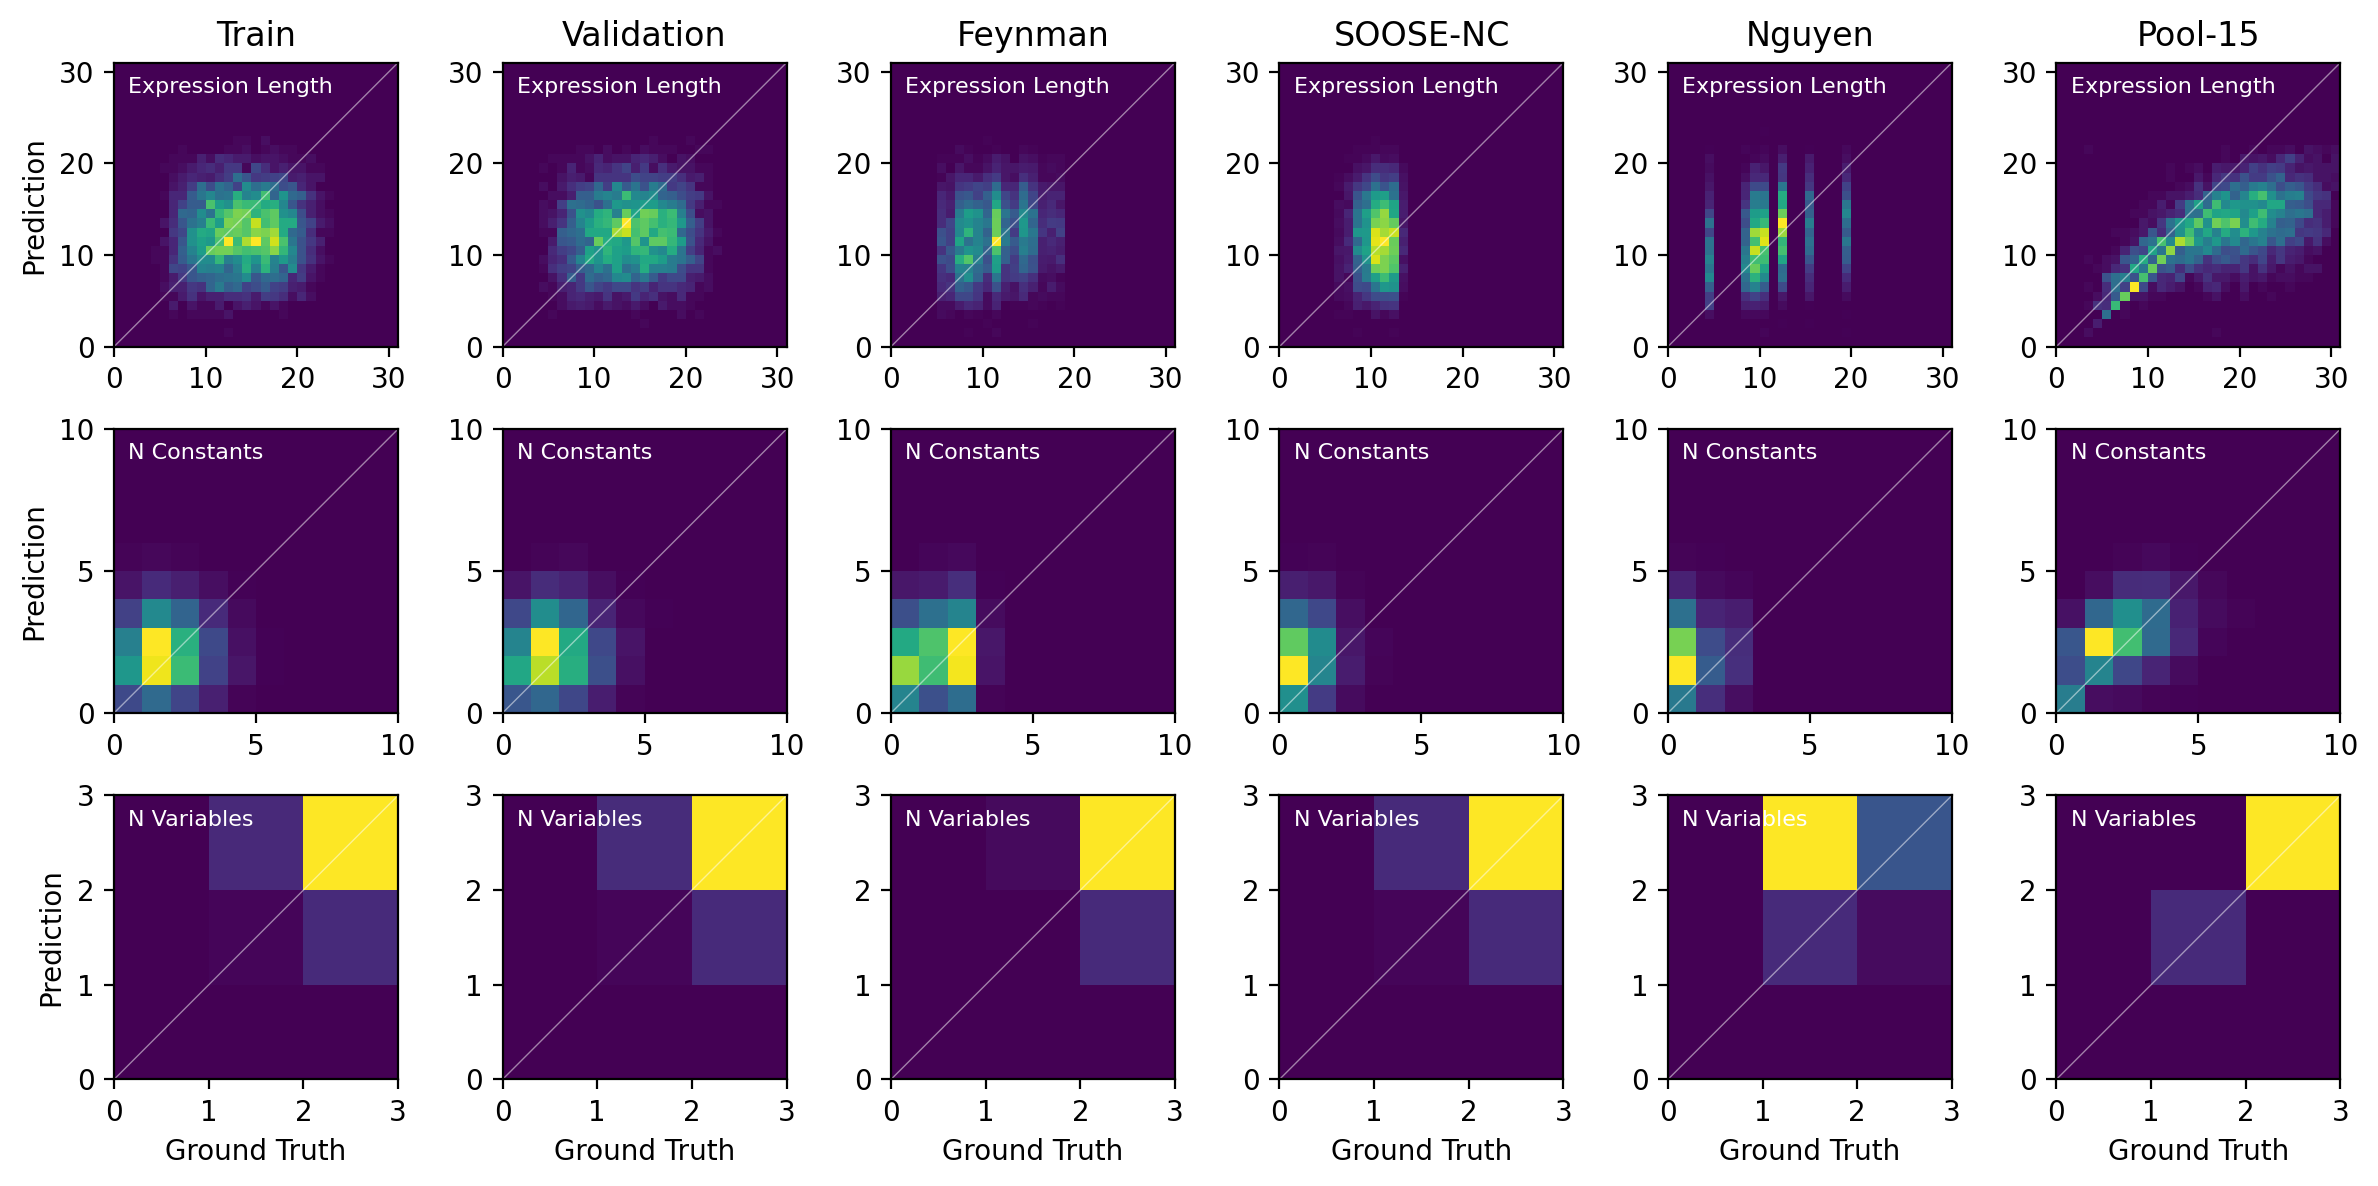

In [16]:
comparisons = [
    ('length_target', 'length_pred'),
    ('n_constants_target', 'n_constants_pred'),
    ('n_unique_variables_target', 'n_unique_variables_pred'),
]

ticks_list = [
    [0, 10, 20, 30],
    [0, 5, 10],
    [0, 1, 2, 3]
]

lims = [
    31, 10, 3
]

COLS = len(results[MODEL])
ROWS = len(comparisons)


fig, ax = plt.subplots(ROWS, COLS, figsize=(2 * COLS, 2 * ROWS), dpi=200)

for i, (comparison, ticks, lim, (target, pred)) in enumerate(zip(['Expression Length', 'N Constants', 'N Variables'], ticks_list, lims, comparisons)):
    for j, (test_set, test_set_results) in enumerate(results[MODEL].items()):
        max_value = max(lim, max(np.nanmax(test_set_results['data'][target]), np.nanmax(test_set_results['data'][pred])))
        ax[i, j].hist2d(test_set_results['data'][target], test_set_results['data'][pred], bins=np.arange(0, max_value + 1, 1), rasterized=True, cmap='viridis')
        if i == len(comparisons) - 1:
            ax[i, j].set_xlabel('Ground Truth')
        if j == 0:
            ax[i, j].set_ylabel('Prediction')
        if i == 0:
            ax[i, j].set_title(f'{TEST_SET_TITLES_LONG[test_set]}')

        # if j == 0:
        ax[i, j].annotate(comparison, (0.05, 0.95), xycoords='axes fraction', ha='left', va='top', color='w', fontsize=8)

        ax[i, j].plot([0, max_value], [0, max_value], 'w', alpha=0.5, lw=0.5)

        ax[i, j].set_aspect('equal')

        ax[i, j].set_xticks(ticks)
        ax[i, j].set_yticks(ticks)

        ax[i, j].set_facecolor(plt.get_cmap('viridis')(0))
        ax[i, j].set_xlim(0, lim)
        ax[i, j].set_ylim(0, lim)

fig.tight_layout()

# Embeddings

In [17]:
from flash_ansr import SkeletonPool, FlashANSRTransformer, NoValidSampleFoundError
from flash_ansr.expressions.utils import codify, num_to_constants
import torch
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from scipy.spatial.distance import cosine
from sklearn.metrics import davies_bouldin_score


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
pool = SkeletonPool.from_config(get_path('configs', MODEL, 'skeleton_pool_train.yaml'))
pool.sample_strategy['max_tries'] = 100
# flash_ansr_transformer = FlashANSRTransformer.from_config(get_path('configs', MODEL, 'nsr.yaml')).eval().to(device)  # NEED TO LOAD THE MODEL! NOT INITIALIZE IT
flash_ansr_transformer = FlashANSRTransformer.load(get_path('models', 'ansr-models', MODEL))[1].eval().to(device)

Compiling Skeletons: 100%|██████████| 4999/4999 [00:00<00:00, 27119.10it/s]


In [19]:
def get_embeddings_for_skeleton(skeleton: list[str], x: np.ndarray, skeleton_pool: SkeletonPool, n_embeddings: int = 100, n_support: int = 512, verbose: bool = False) -> np.ndarray:
    executable_prefix_expression = skeleton_pool.expression_space.operators_to_realizations(skeleton)
    prefix_expression_with_constants, constants = num_to_constants(executable_prefix_expression)
    code_string = skeleton_pool.expression_space.prefix_to_infix(prefix_expression_with_constants, realization=True)
    code = codify(code_string, skeleton_pool.expression_space.variables + constants)

    embeddings_list = []

    pool.sample_strategy['independent_dimensions'] = False

    x = x.reshape(-1, len(pool.expression_space.variables))

    # Determine the bounds of the x data (unbiased estimators)
    a = x.min(0) - (x.max(0) - x.min(0)) / x.shape[0]
    b = x.max(0) + (x.max(0) - x.min(0)) / x.shape[0]

    # Sample in the same interval as the original data
    def support_prior(size: tuple[int]) -> np.ndarray:
        return np.concatenate([np.random.uniform(a[j], b[j], size=(size[0], 1)) for j in range(size[1])], axis=1).astype(np.float32)

    for _ in tqdm(range(n_embeddings), disable=not verbose):
        X, Y, _ = pool.sample_data(code, len(constants), n_support, support_prior=support_prior)

        # Set all x that do not appear in the expression to 0
        for i, variable in enumerate(pool.expression_space.variables):
            if variable not in skeleton:
                X[:, i] = 0

        data_tensor = torch.tensor(np.concatenate([X, Y], axis=1), device=device).unsqueeze(0)

        pre_encodings = flash_ansr_transformer.pre_encoder(data_tensor)
        memory = flash_ansr_transformer.encoder(pre_encodings)[0].flatten()

        embeddings_list.append(memory.detach().cpu().numpy())

    embeddings = np.stack(embeddings_list)
    
    pool.sample_strategy['independent_dimensions'] = True

    return embeddings

def similarities(embeddings: np.ndarray, embeddings_pred: np.ndarray):
    n_embeddings = embeddings.shape[0]
    n_embeddings_pred = embeddings_pred.shape[0]

    # Compute the pairwise similarities
    inter_similarities = np.zeros((n_embeddings, n_embeddings))
    inter_similarities_pred = np.zeros((n_embeddings_pred, n_embeddings_pred))
    intra_similarities = np.zeros((n_embeddings, n_embeddings_pred))

    def similarity(x, y):
        return 1 - cosine(x, y)

    for i in range(n_embeddings):
        for j in range(n_embeddings):
            inter_similarities[i, j] = similarity(embeddings[i], embeddings[j])

    for i in range(n_embeddings_pred):
        for j in range(n_embeddings_pred):
            inter_similarities_pred[i, j] = similarity(embeddings_pred[i], embeddings_pred[j])

    for i in range(n_embeddings):
        for j in range(n_embeddings_pred):
            intra_similarities[i, j] = similarity(embeddings[i], embeddings_pred[j])

    return inter_similarities, inter_similarities_pred, intra_similarities

In [20]:
# Add the davies bouldin index
def davies_bouldin(embeddings, embeddings_pred):
    X = np.concatenate([embeddings, embeddings_pred], axis=0)
    labels = np.concatenate([np.zeros(embeddings.shape[0]), np.ones(embeddings_pred.shape[0])])

    return davies_bouldin_score(X, labels)

In [21]:
# Add the silhouette score
from sklearn.metrics import silhouette_score

def silhouette(embeddings, embeddings_pred):
    # https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c
    X = np.concatenate([embeddings, embeddings_pred], axis=0)
    labels = np.concatenate([np.zeros(embeddings.shape[0]), np.ones(embeddings_pred.shape[0])])

    return silhouette_score(X, labels)

In [22]:
contrastive_loss_fn = ContrastiveLoss(margin=0.5, temperature=0.5)

def contrastive_loss(embeddings, embeddings_pred):
    X = np.concatenate([embeddings, embeddings_pred], axis=0)
    labels = np.concatenate([np.zeros(embeddings.shape[0]), np.ones(embeddings_pred.shape[0])])

    return contrastive_loss_fn(torch.tensor(X), torch.tensor(labels))

In [23]:
if not READ:
    consisteny_results = {}

    for test_set in results[MODEL].keys():
        intra_similarities_list = []
        intra_similarities_pred_list = []
        inter_similarities_list = []
        embedding_davies_bouldin_list = []
        embedding_silhouette_list = []
        embedding_contrastive_list = []

        print(f'{test_set}')

        for i in tqdm(range(len(results[MODEL][test_set]['data']['x'])), desc=f'Computing similarities'):
            x = results[MODEL][test_set]['data']['x'][i]

            try:
                skeleton = pool.expression_space.tokenizer.decode(results[MODEL][test_set]['data']['input_ids'][i][1:-1])
                skeleton_pred = pool.expression_space.tokenizer.decode(results[MODEL][test_set]['data'][f"free_beam_{int(results[MODEL][test_set]['data']['best_beam'][i])}"][i])

                embeddings = get_embeddings_for_skeleton(skeleton, x, pool, n_embeddings=64, verbose=False)
                embeddings_pred = get_embeddings_for_skeleton(skeleton_pred, x, pool, n_embeddings=64, verbose=False)

                # Custom similarity metric
                intra_similarities, intra_similarities_pred, inter_similarities = similarities(embeddings, embeddings_pred)

                intra_similarities_list.append(intra_similarities)
                intra_similarities_pred_list.append(intra_similarities_pred)
                inter_similarities_list.append(inter_similarities)

                # Compute the davies bouldin index of the embeddings
                embedding_davies_bouldin_list.append(davies_bouldin(embeddings, embeddings_pred))

                # Compute the silhouette score of the embeddings
                embedding_silhouette_list.append(silhouette(embeddings, embeddings_pred))

                # Compute the contrastive loss of the embeddings
                embedding_contrastive_list.append(contrastive_loss(embeddings, embeddings_pred))

            except (NoValidSampleFoundError, ValueError):
                intra_similarities_list.append(np.nan)
                intra_similarities_pred_list.append(np.nan)
                inter_similarities_list.append(np.nan)
                embedding_davies_bouldin_list.append(np.nan)
                embedding_silhouette_list.append(np.nan)
                embedding_contrastive_list.append(np.nan)

        results[MODEL][test_set]['data']['intra_similarities_list'] = intra_similarities_list
        results[MODEL][test_set]['data']['intra_similarities_pred_list'] = intra_similarities_pred_list
        results[MODEL][test_set]['data']['inter_similarities_list'] = inter_similarities_list
        results[MODEL][test_set]['data']['embedding_davies_bouldin'] = np.array(embedding_davies_bouldin_list)
        results[MODEL][test_set]['data']['embedding_silhouette'] = np.array(embedding_silhouette_list)
        results[MODEL][test_set]['data']['embedding_contrastive'] = np.array(embedding_contrastive_list)

        intra_similarities_mean_list = []
        intra_similarities_pred_mean_list = []
        inter_similarities_mean_list = []

        for i in range(len(intra_similarities_list)):
            if isinstance(intra_similarities_list[i], np.ndarray):
                intra_similarities_mean_list.append((intra_similarities_list[i] - np.diag(np.ones(intra_similarities_list[i].shape[0]))).mean())
                intra_similarities_pred_mean_list.append((intra_similarities_pred_list[i] - np.diag(np.ones(intra_similarities_pred_list[i].shape[0]))).mean())
                inter_similarities_mean_list.append(np.mean(inter_similarities_list[i]))
            else:
                intra_similarities_mean_list.append(np.nan)
                intra_similarities_pred_mean_list.append(np.nan)
                inter_similarities_mean_list.append(np.nan)

        intra_similarities_mean = np.array(intra_similarities_mean_list)
        intra_similarities_pred_mean = np.array(intra_similarities_pred_mean_list)
        inter_similarities_mean = np.array(inter_similarities_mean_list)

        results[MODEL][test_set]['data']['intra_similarities_mean'] = intra_similarities_mean
        results[MODEL][test_set]['data']['intra_similarities_pred_mean'] = intra_similarities_pred_mean
        results[MODEL][test_set]['data']['inter_similarities_mean'] = inter_similarities_mean

        embedding_consistency = (2 * inter_similarities_mean) / (intra_similarities_mean + intra_similarities_pred_mean)

        results[MODEL][test_set]['data']['embedding_consistency'] = embedding_consistency

        consisteny_results[test_set] = {
            k: results[MODEL][test_set]['data'][k]
            for k in [
                'intra_similarities_list', 'intra_similarities_pred_list', 'inter_similarities_list',
                'intra_similarities_mean', 'intra_similarities_pred_mean', 'inter_similarities_mean',
                'embedding_consistency', 'embedding_davies_bouldin', 'embedding_silhouette', 'embedding_contrastive'
            ]
        }

    print('Saving results')
    with open(get_path('results', 'embedding_consistency', create=True, filename=f'{MODEL}_results.pickle'), 'wb') as f:
        pickle.dump(consisteny_results, f)
    print('Results saved')
else:
    print('Loading results')
    with open(get_path('results', 'embedding_consistency', filename=f'{MODEL}_results.pickle'), 'rb') as f:
        consisteny_results = pickle.load(f)

    for test_set, test_set_results in consisteny_results.items():
        for k, v in test_set_results.items():
            results[MODEL][test_set]['data'][k] = v
    print('Results loaded')

train


Computing similarities: 100%|██████████| 5000/5000 [1:13:41<00:00,  1.13it/s]


val


Computing similarities: 100%|██████████| 5000/5000 [1:11:28<00:00,  1.17it/s]


feynman


Computing similarities: 100%|██████████| 5000/5000 [1:10:21<00:00,  1.18it/s]


soose_nc


Computing similarities: 100%|██████████| 5000/5000 [1:11:34<00:00,  1.16it/s]


nguyen


Computing similarities: 100%|██████████| 5000/5000 [1:13:18<00:00,  1.14it/s]


pool_15


Computing similarities: 100%|██████████| 5000/5000 [1:12:05<00:00,  1.16it/s]


Saving results
Results saved


In [24]:
# for test_set in consisteny_results.keys():
#     indices_of_nans = np.where(np.isnan(results["v7.0"][test_set]["data"]['embedding_consistency']))[0]
#     for metric in ['embedding_davies_bouldin', 'embedding_silhouette', 'embedding_contrastive']:
#         # Insert nans at the positions of the nans in embedding_consistency
#         updated_results = np.copy(results["v7.0"][test_set]["data"][metric])
#         for i in indices_of_nans:
#             results["v7.0"][test_set]["data"][metric] = np.insert(results["v7.0"][test_set]["data"][metric], i, np.nan)

100%|██████████| 6/6 [00:25<00:00,  4.18s/it]
/tmp/ipykernel_17107/1652908818.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


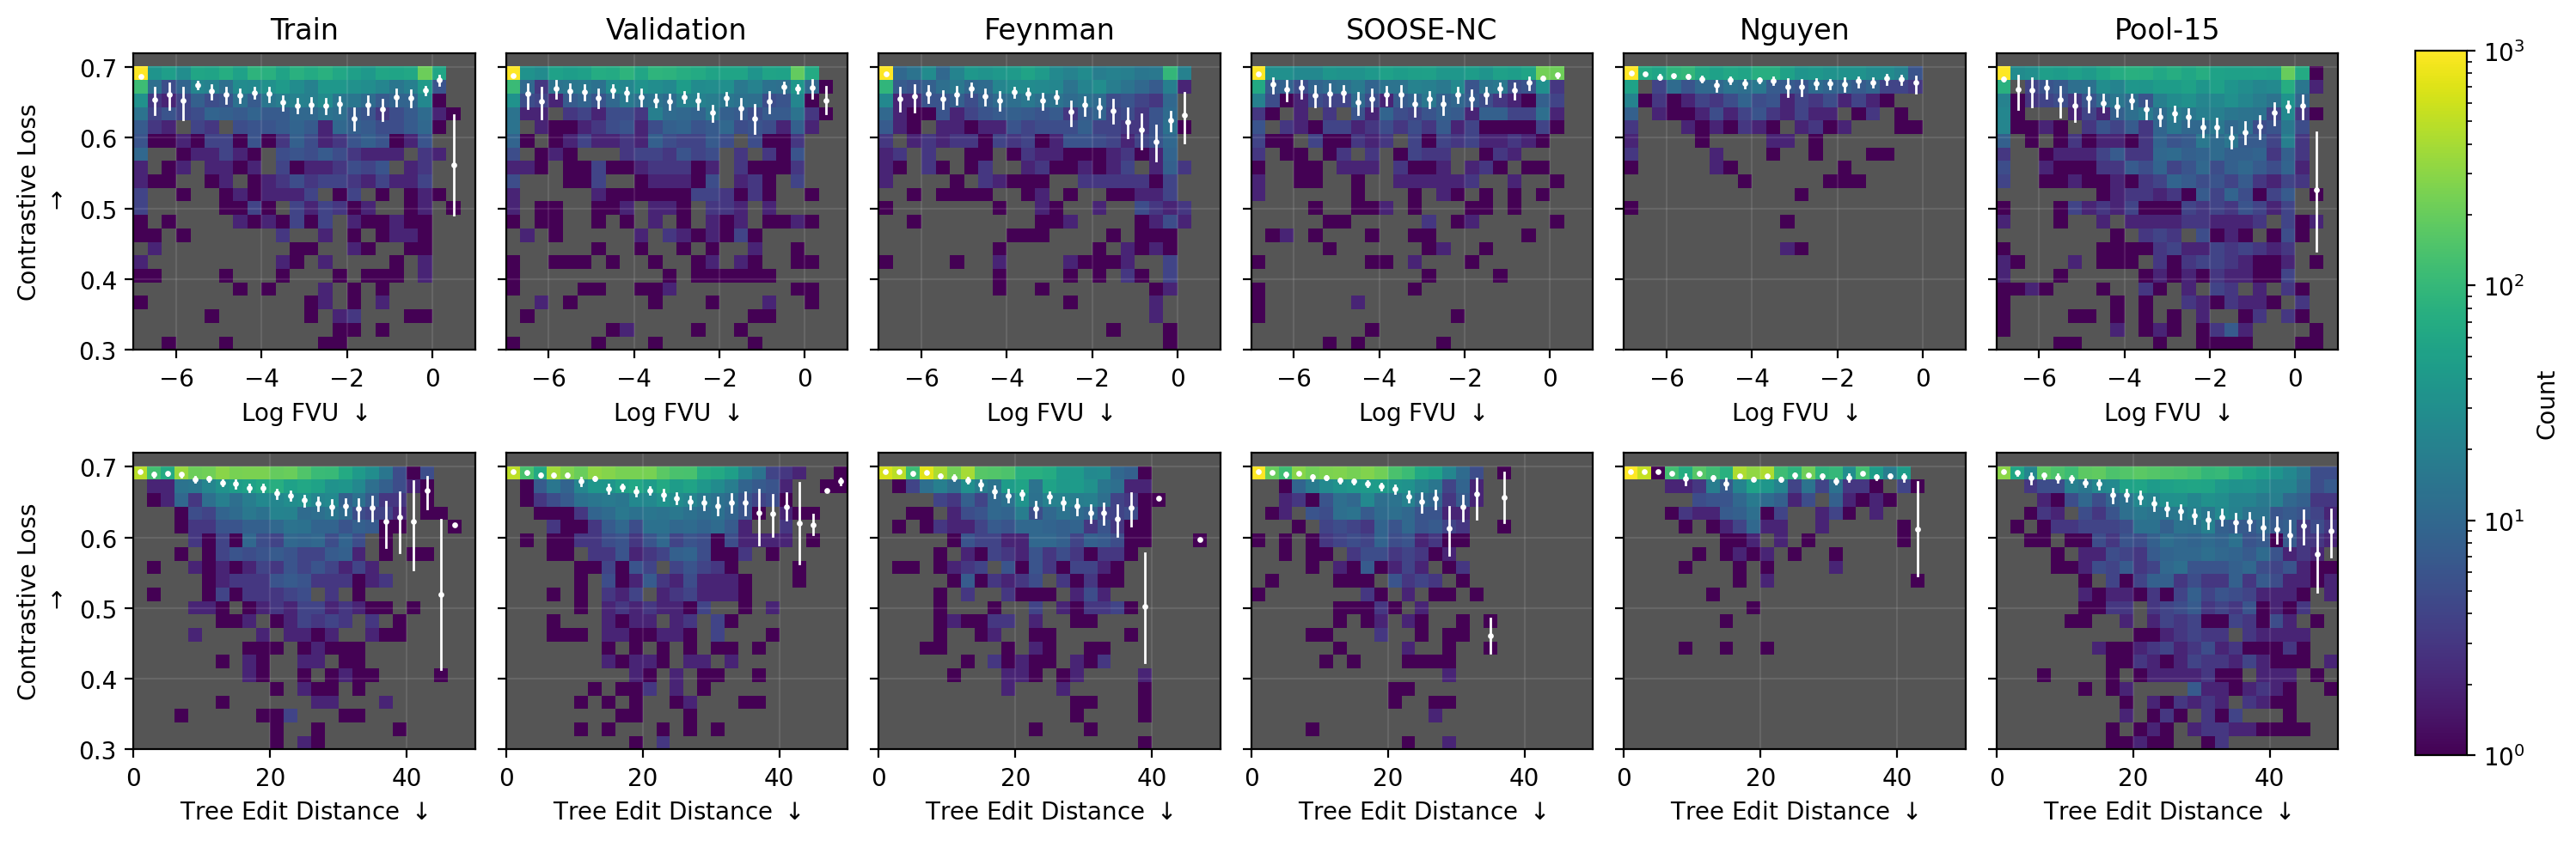

In [25]:
fig, axes = plt.subplots(2, len(TEST_SETS), figsize=(2.5 * len(TEST_SETS), 5), dpi=200, sharey=True)

images = []

for col_i, (axes_col, test_set) in enumerate(zip(tqdm(axes.T), TEST_SETS)):
    if not 'embedding_contrastive' in results[MODEL][test_set]['data']:
        continue
    for row_i, (ax, x_data, y_data, xbins, ybins) in enumerate(zip(
        axes_col,
        [results[MODEL][test_set]['data']['log_fvu'], results[MODEL][test_set]['data']['tree_edit_distance_best_beam']],
        [results[MODEL][test_set]['data']['embedding_contrastive'], results[MODEL][test_set]['data']['embedding_contrastive']],
        [np.linspace(-7, 1, 25), np.linspace(0, 50, 26)],
        [np.linspace(0.3, 0.72, 23), np.linspace(0.3, 0.72, 23)])):

        images.append(ax.hist2d(x_data, y_data, bins=(xbins, ybins), norm=LogNorm(vmin=1, vmax=1e3)))

        x_list = []
        y_list = []
        y_upper_list = []
        y_lower_list = []
        for i in range(len(xbins) - 1):
            mask = (x_data >= xbins[i]) & (x_data < xbins[i + 1])
            if np.any(mask):
                statistic, lower, upper = bootstrapped_metric_ci(y_data[mask], np.nanmean)
                x_list.append((xbins[i] + xbins[i + 1]) / 2)
                y_list.append(statistic)
                y_upper_list.append(upper)
                y_lower_list.append(lower)
        ax.scatter(x_list, y_list, color='w', s=2)
        for x, y, y_upper, y_lower in zip(x_list, y_list, y_upper_list, y_lower_list):
            ax.plot([x, x], [y_lower, y_upper], color='w', lw=1)
            
        # Add labels
        if col_i == 0:
            axes[0, col_i].set_ylabel('Contrastive Loss\n$\\rightarrow$')  # Want same embeddings despite different "labels" (GT and Pred)
            axes[1, col_i].set_ylabel('Contrastive Loss\n$\\rightarrow$')
        if row_i == 0:
            axes[row_i, col_i].set_title(TEST_SET_TITLES_LONG[test_set])
    
    axes_col[0].set_xlabel('Log FVU $\\downarrow$')
    axes_col[1].set_xlabel('Tree Edit Distance $\\downarrow$')

# # Add a colorbar in a new axis
cbar_ax = fig.add_axes([0.94, 0.11, 0.02, 0.82])
fig.colorbar(ScalarMappable(norm=LogNorm(vmin=1, vmax=1e3), cmap="viridis"), cax=cbar_ax, label='Count')

for ax in axes.flatten():
    ax.set_facecolor('#555555')
    ax.grid(color='white', alpha=0.1)

fig.tight_layout()
fig.subplots_adjust(right=0.91)

plt.savefig(get_path('results', 'embedding_consistency', create=True, filename=f'heatmaps_contrastive_{MODEL}.svg'), bbox_inches='tight')

100%|██████████| 6/6 [00:24<00:00,  4.10s/it]
/tmp/ipykernel_17107/2146855760.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


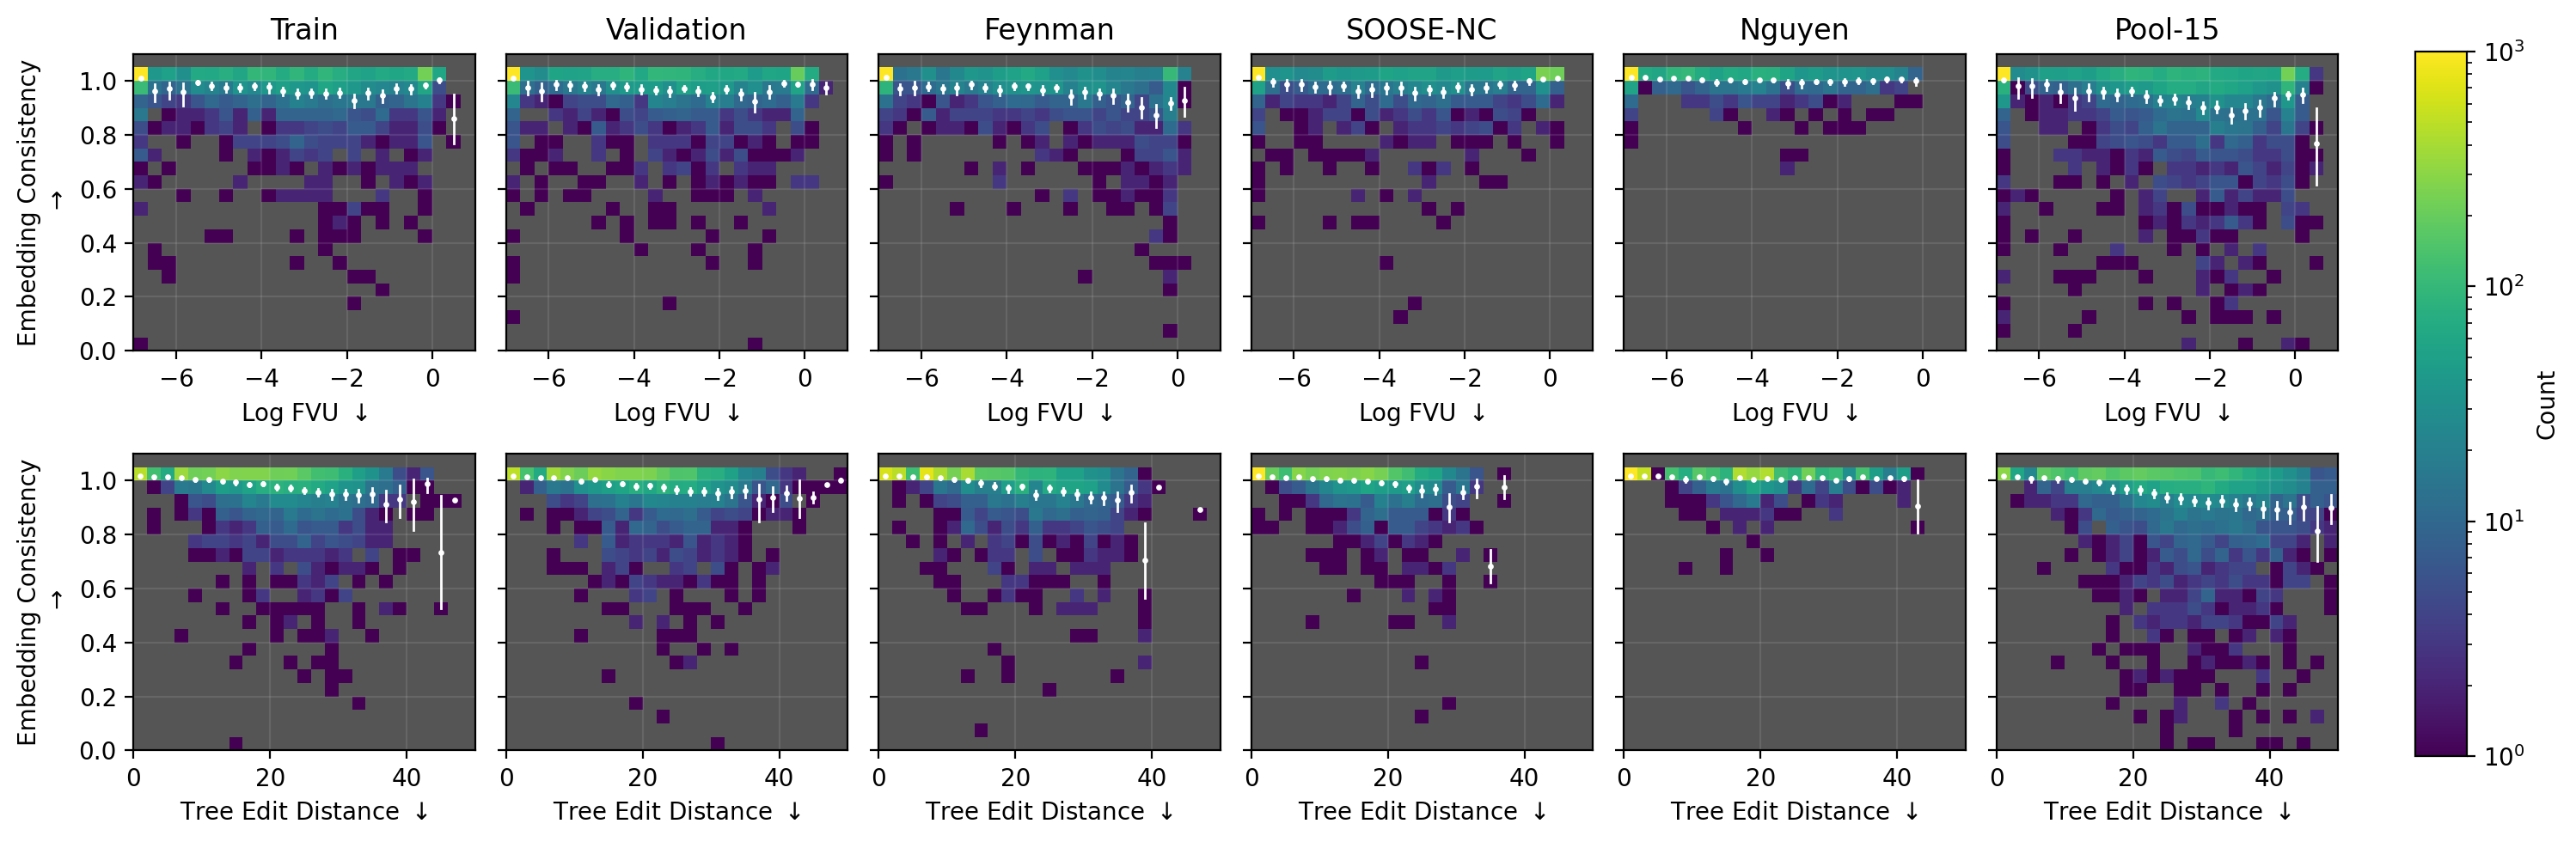

In [26]:
fig, axes = plt.subplots(2, len(TEST_SETS), figsize=(2.5 * len(TEST_SETS), 5), dpi=200, sharey=True)

images = []

for col_i, (axes_col, test_set) in enumerate(zip(tqdm(axes.T), TEST_SETS)):
    if not 'embedding_consistency' in results[MODEL][test_set]['data']:
        continue
    for row_i, (ax, x_data, y_data, xbins, ybins) in enumerate(zip(
        axes_col,
        [results[MODEL][test_set]['data']['log_fvu'], results[MODEL][test_set]['data']['tree_edit_distance_best_beam']],
        [results[MODEL][test_set]['data']['embedding_consistency'], results[MODEL][test_set]['data']['embedding_consistency']],
        [np.linspace(-7, 1, 25), np.linspace(0, 50, 26)],
        [np.linspace(0, 1.1, 23), np.linspace(0, 1.1, 23)])):

        images.append(ax.hist2d(x_data, y_data, bins=(xbins, ybins), norm=LogNorm(vmin=1, vmax=1e3)))

        x_list = []
        y_list = []
        y_upper_list = []
        y_lower_list = []
        for i in range(len(xbins) - 1):
            mask = (x_data >= xbins[i]) & (x_data < xbins[i + 1])
            if np.any(mask):
                statistic, lower, upper = bootstrapped_metric_ci(y_data[mask], np.nanmean)
                x_list.append((xbins[i] + xbins[i + 1]) / 2)
                y_list.append(statistic)
                y_upper_list.append(upper)
                y_lower_list.append(lower)
        ax.scatter(x_list, y_list, color='w', s=2)
        for x, y, y_upper, y_lower in zip(x_list, y_list, y_upper_list, y_lower_list):
            ax.plot([x, x], [y_lower, y_upper], color='w', lw=1)
            
        # Add labels
        if col_i == 0:
            axes[0, col_i].set_ylabel('Embedding Consistency\n$\\rightarrow$')
            axes[1, col_i].set_ylabel('Embedding Consistency\n$\\rightarrow$')
        if row_i == 0:
            axes[row_i, col_i].set_title(TEST_SET_TITLES_LONG[test_set])
    
    axes_col[0].set_xlabel('Log FVU $\\downarrow$')
    axes_col[1].set_xlabel('Tree Edit Distance $\\downarrow$')

# # Add a colorbar in a new axis
cbar_ax = fig.add_axes([0.94, 0.11, 0.02, 0.82])
fig.colorbar(ScalarMappable(norm=LogNorm(vmin=1, vmax=1e3), cmap="viridis"), cax=cbar_ax, label='Count')

for ax in axes.flatten():
    ax.set_facecolor('#555555')
    ax.grid(color='white', alpha=0.1)

fig.tight_layout()
fig.subplots_adjust(right=0.91)

plt.savefig(get_path('results', 'embedding_consistency', create=True, filename=f'heatmaps_custom_{MODEL}.svg'), bbox_inches='tight')

100%|██████████| 6/6 [00:23<00:00,  3.98s/it]
/tmp/ipykernel_17107/1867772879.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


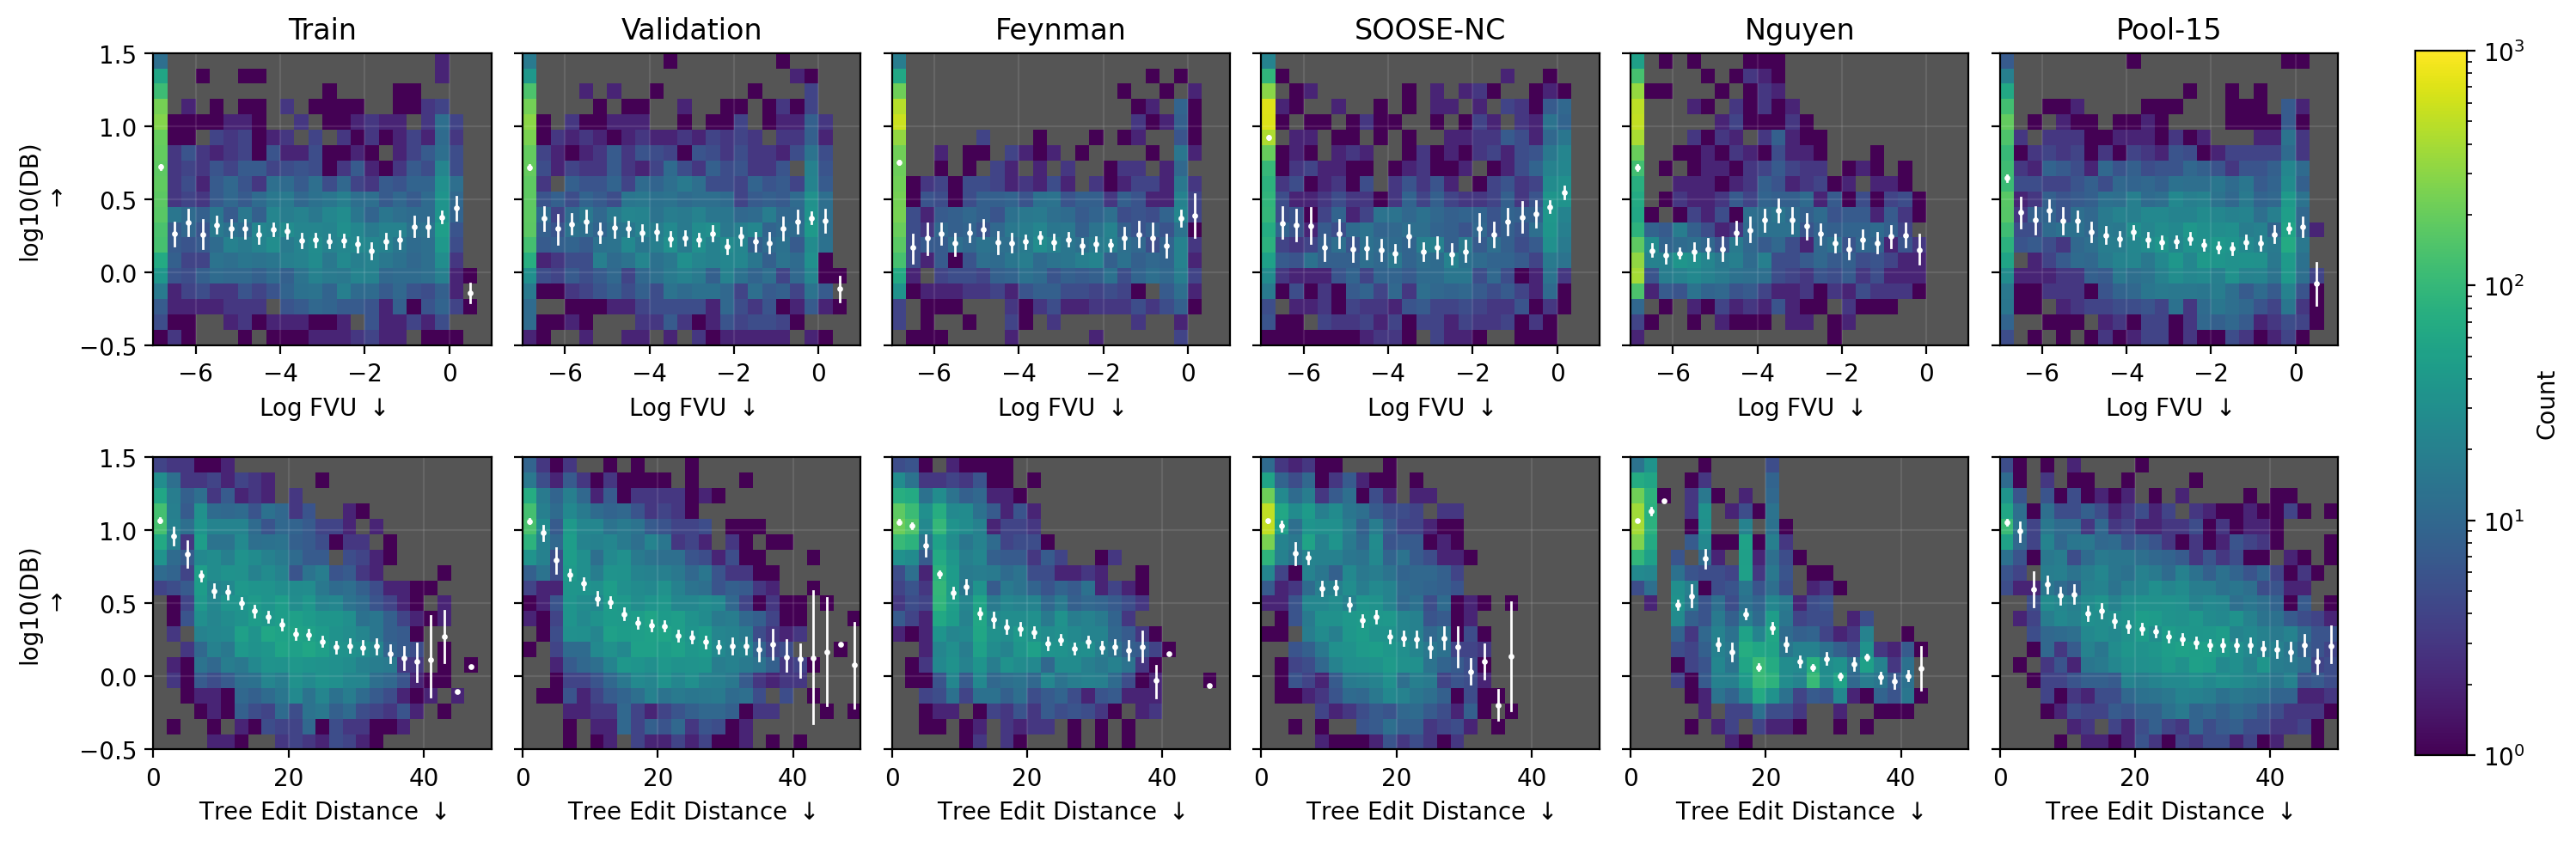

In [27]:
fig, axes = plt.subplots(2, len(TEST_SETS), figsize=(2.5 * len(TEST_SETS), 5), dpi=200, sharey=True)

images = []

for col_i, (axes_col, test_set) in enumerate(zip(tqdm(axes.T), TEST_SETS)):
    if not 'embedding_davies_bouldin' in results[MODEL][test_set]['data']:
        continue
    for row_i, (ax, x_data, y_data, xbins, ybins) in enumerate(zip(
        axes_col,
        [results[MODEL][test_set]['data']['log_fvu'], results[MODEL][test_set]['data']['tree_edit_distance_best_beam']],
        [np.log10(results[MODEL][test_set]['data']['embedding_davies_bouldin']), np.log10(results[MODEL][test_set]['data']['embedding_davies_bouldin'])],
        [np.linspace(-7, 1, 25), np.linspace(0, 50, 26)],
        [np.linspace(-0.5, 1.5, 20), np.linspace(-0.5, 1.5, 20)])):

        images.append(ax.hist2d(x_data, y_data, bins=(xbins, ybins), norm=LogNorm(vmin=1, vmax=1e3)))

        x_list = []
        y_list = []
        y_upper_list = []
        y_lower_list = []
        for i in range(len(xbins) - 1):
            mask = (x_data >= xbins[i]) & (x_data < xbins[i + 1])
            if np.any(mask):
                statistic, lower, upper = bootstrapped_metric_ci(y_data[mask], np.nanmean)
                x_list.append((xbins[i] + xbins[i + 1]) / 2)
                y_list.append(statistic)
                y_upper_list.append(upper)
                y_lower_list.append(lower)
        ax.scatter(x_list, y_list, color='w', s=2)
        for x, y, y_upper, y_lower in zip(x_list, y_list, y_upper_list, y_lower_list):
            ax.plot([x, x], [y_lower, y_upper], color='w', lw=1)
            
        # Add labels
        if col_i == 0:
            axes[0, col_i].set_ylabel('log10(DB)\n$\\rightarrow$')
            axes[1, col_i].set_ylabel('log10(DB)\n$\\rightarrow$')
        if row_i == 0:
            axes[row_i, col_i].set_title(TEST_SET_TITLES_LONG[test_set])
    
    axes_col[0].set_xlabel('Log FVU $\\downarrow$')
    axes_col[1].set_xlabel('Tree Edit Distance $\\downarrow$')

# # Add a colorbar in a new axis
cbar_ax = fig.add_axes([0.94, 0.11, 0.02, 0.82])
fig.colorbar(ScalarMappable(norm=LogNorm(vmin=1, vmax=1e3), cmap="viridis"), cax=cbar_ax, label='Count')

for ax in axes.flatten():
    ax.set_facecolor('#555555')
    ax.grid(color='white', alpha=0.1)

fig.tight_layout()
fig.subplots_adjust(right=0.91)

plt.savefig(get_path('results', 'embedding_consistency', create=True, filename=f'heatmaps_db_{MODEL}.svg'), bbox_inches='tight')

In [28]:
# Data of a predicted expression which is different enough to the true expression to result in bad FVU should also differ in a similar amount from the ground truth data when embedded.
# In other words: Predicted and GT expressions should produce data that is embedded similarly when the fit is good. Data from different expressions (as is the case when the fit is bad) should be embedded differently.
# Observation: the worse the fit, the more similar the embeddings are, which is unexpected.
# Hypothesis: the embeddings are not good

100%|██████████| 6/6 [00:00<00:00, 38.43it/s]
/tmp/ipykernel_17107/58058538.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


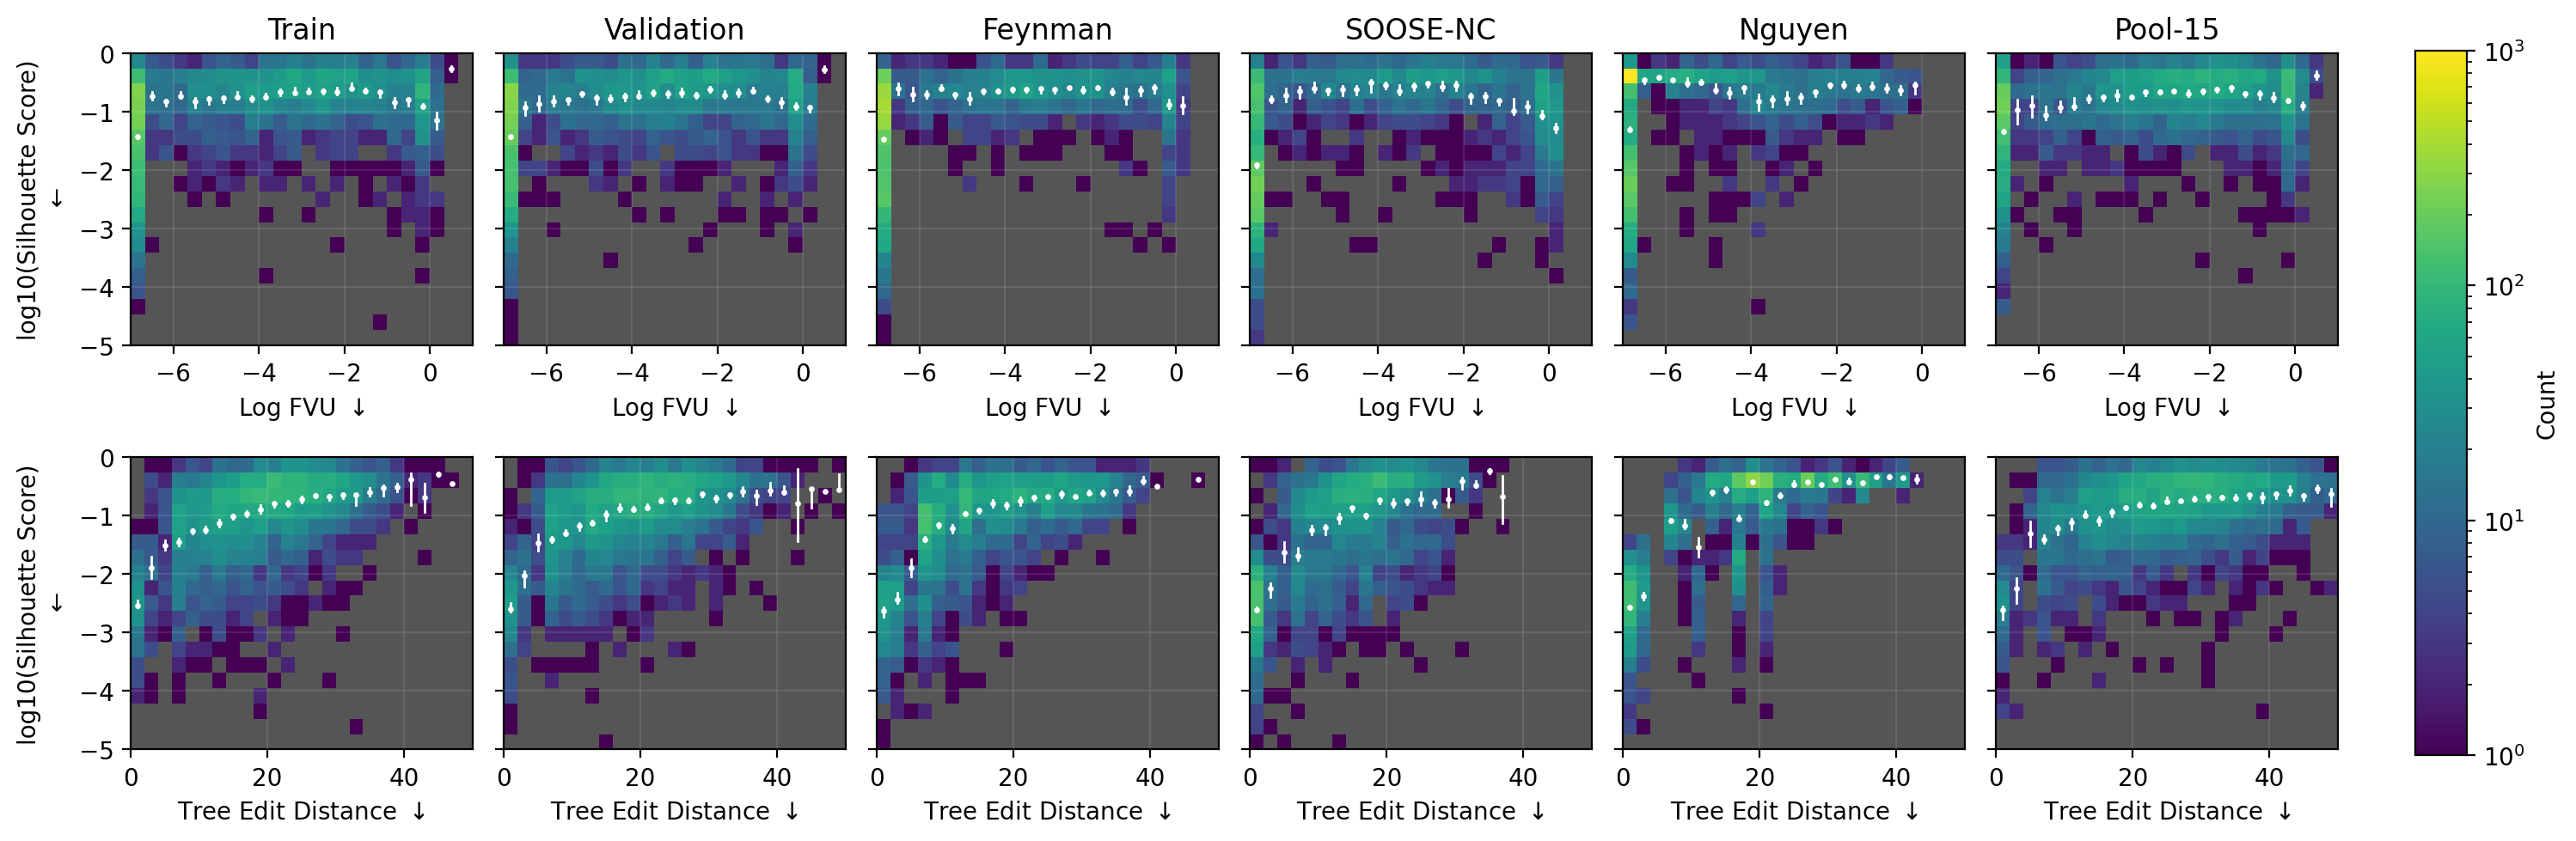

In [29]:
fig, axes = plt.subplots(2, len(TEST_SETS), figsize=(2.5 * len(TEST_SETS), 5), dpi=200, sharey=True)

images = []

for col_i, (axes_col, test_set) in enumerate(zip(tqdm(axes.T), TEST_SETS)):
    if not 'embedding_silhouette' in results[MODEL][test_set]['data']:
        continue
    for row_i, (ax, x_data, y_data, xbins, ybins) in enumerate(zip(
        axes_col,
        [results[MODEL][test_set]['data']['log_fvu'], results[MODEL][test_set]['data']['tree_edit_distance_best_beam']],
        [np.log10(results[MODEL][test_set]['data']['embedding_silhouette']), np.log10(results[MODEL][test_set]['data']['embedding_silhouette'])],
        [np.linspace(-7, 1, 25), np.linspace(0, 50, 26)],
        [np.linspace(-5, 0, 20), np.linspace(-5, 0, 20)])):

        images.append(ax.hist2d(x_data, y_data, bins=(xbins, ybins), norm=LogNorm(vmin=1, vmax=1e3)))

        x_list = []
        y_list = []
        y_upper_list = []
        y_lower_list = []
        for i in range(len(xbins) - 1):
            mask = (x_data >= xbins[i]) & (x_data < xbins[i + 1])
            if np.any(mask):
                statistic, lower, upper = bootstrapped_metric_ci(y_data[mask], np.nanmean, n=10)
                x_list.append((xbins[i] + xbins[i + 1]) / 2)
                y_list.append(statistic)
                y_upper_list.append(upper)
                y_lower_list.append(lower)
        ax.scatter(x_list, y_list, color='w', s=2)
        for x, y, y_upper, y_lower in zip(x_list, y_list, y_upper_list, y_lower_list):
            ax.plot([x, x], [y_lower, y_upper], color='w', lw=1)
            
        # Add labels
        if col_i == 0:
            axes[0, col_i].set_ylabel('log10(Silhouette Score)\n$\\leftarrow$')
            axes[1, col_i].set_ylabel('log10(Silhouette Score)\n$\\leftarrow$')
        if row_i == 0:
            axes[row_i, col_i].set_title(TEST_SET_TITLES_LONG[test_set])
    
    axes_col[0].set_xlabel('Log FVU $\\downarrow$')
    axes_col[1].set_xlabel('Tree Edit Distance $\\downarrow$')

# # Add a colorbar in a new axis
cbar_ax = fig.add_axes([0.94, 0.11, 0.02, 0.82])
fig.colorbar(ScalarMappable(norm=LogNorm(vmin=1, vmax=1e3), cmap="viridis"), cax=cbar_ax, label='Count')

for ax in axes.flatten():
    ax.set_facecolor('#555555')
    ax.grid(color='white', alpha=0.1)

fig.tight_layout()
fig.subplots_adjust(right=0.91)

plt.savefig(get_path('results', 'embedding_consistency', create=True, filename=f'heatmaps_silhouette_{MODEL}.svg'), bbox_inches='tight')

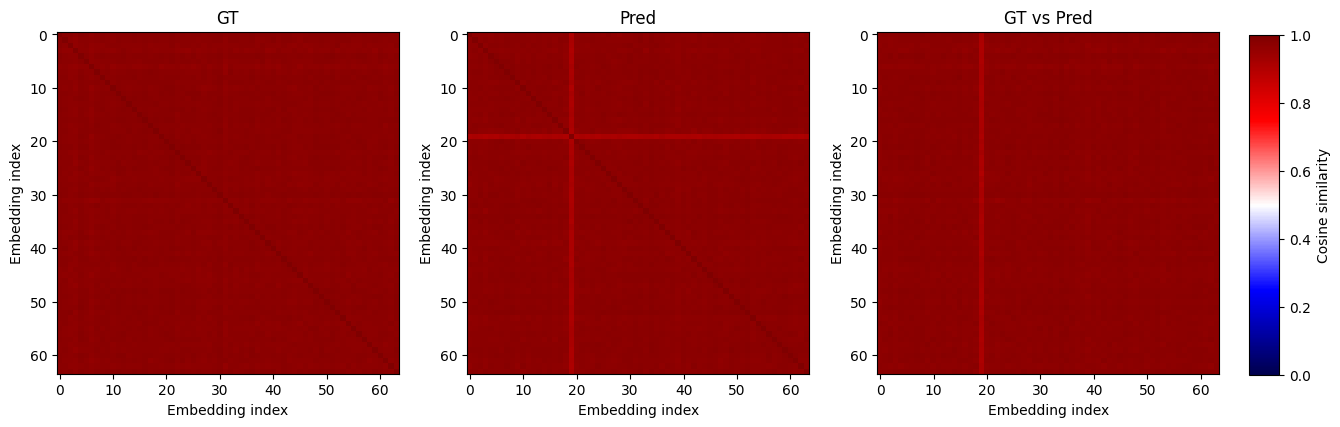

In [109]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

id = 9

ax[0].imshow(consisteny_results['val']['intra_similarities_list'][id], cmap='seismic', vmin=-1, vmax=1)
ax[0].set_title('GT')
ax[0].set_xlabel('Embedding index')
ax[0].set_ylabel('Embedding index')

ax[1].imshow(consisteny_results['val']['intra_similarities_pred_list'][id], cmap='seismic', vmin=-1, vmax=1)
ax[1].set_title('Pred')
ax[1].set_xlabel('Embedding index')
ax[1].set_ylabel('Embedding index')

ax[2].imshow(consisteny_results['val']['inter_similarities_list'][id], cmap='seismic', vmin=-1, vmax=1)
ax[2].set_title('GT vs Pred')
ax[2].set_xlabel('Embedding index')
ax[2].set_ylabel('Embedding index')

# Colobar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.68])
fig.colorbar(ScalarMappable(cmap='seismic'), cax=cbar_ax, label='Cosine similarity')

# SHAP

In [110]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'x_val', 'y_val', 'y_noisy_val', 'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam', 'y_noisy'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
compare_columns = compare_columns - {c for c in compare_columns if '_list' in c}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
# compare_columns

In [111]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [112]:
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [113]:
array_dfs['v7.0']['train'].keys()

Index(['beam_search_time', 'perplexity', 'reciprocal_rank', 'wall_time',
       'sys_time', 'length_target', 'n_constants_target',
       'n_unique_variables_target', 'NSRTS_accuracy_close_best_beam',
       'NSRTS_accuracy_close_val_best_beam', 'NSRTS_accuracy_r2_best_beam',
       'NSRTS_accuracy_r2_val_best_beam', 'accuracy_best_beam',
       'bleu_best_beam', 'edit_distance_best_beam', 'f1_score_best_beam',
       'meteor_best_beam', 'mse_best_beam', 'mse_val_best_beam',
       'precision_best_beam', 'r2_best_beam', 'r2_val_best_beam',
       'recall_best_beam', 'refiner_time_best_beam',
       'rouge1_fmeasure_best_beam', 'rouge1_precision_best_beam',
       'rouge1_recall_best_beam', 'rouge2_fmeasure_best_beam',
       'rouge2_precision_best_beam', 'rouge2_recall_best_beam',
       'rougeL_fmeasure_best_beam', 'rougeL_precision_best_beam',
       'rougeL_recall_best_beam', 'structural_accuracy_best_beam',
       'tree_edit_distance_best_beam', 'length_best_beam', 'best_beam',
   

In [114]:
data_properties = []
target = []
# columns = ['test_set', 'length_target', 'n_constants_target', 'n_constants_pred', 'n_unique_variables_target', 'n_unique_variables_pred', 'length_pred', 'embedding_davies_bouldin', 'x_max_span', 'x_min_span']
columns = ['length_target', 'n_constants_target', 'n_constants_pred', 'n_unique_variables_target', 'n_unique_variables_pred', 'length_pred', 'x_max_span', 'x_min_span', 'length_diff']
expressions_gt = []
expressions_pred = []

for test_set, df in array_dfs['v7.0'].items():
    for i, row in df.iterrows():
        data_properties.append([row[k] for k in columns])
        target.append(row['log_fvu'])
        expressions_gt.append(pool.expression_space.tokenizer.decode(results['v7.0'][test_set]['data']['input_ids'][i][1:-1]))
        best_beam = results['v7.0'][test_set]['data']['best_beam'][i]
        if np.isnan(best_beam):
            expressions_pred.append(None)
        else:
            expressions_pred.append(pool.expression_space.tokenizer.decode(results['v7.0'][test_set]['data'][f"free_beam_{int(best_beam)}"][i]))

data_properties = pd.DataFrame(data_properties, columns=columns)
target = np.array(target)

is_finite = np.isfinite(target)
data_properties = data_properties[is_finite]
target = target[is_finite]

# Rename the columns
data_properties = data_properties.rename(columns={
    # 'test_set': 'cat_test_set',
    'length_target': 'num_length_target',
    'n_constants_target': 'num_n_constants_target',
    'n_constants_pred': 'num_n_constants_pred',
    'n_unique_variables_target': 'num_n_unique_variables_target',
    'n_unique_variables_pred': 'num_n_unique_variables_pred',
    'length_pred': 'num_length_pred',
    # 'embedding_davies_bouldin': 'num_embedding_davies_bouldin',
    'x_max_span': 'num_x_max_span',
    'x_min_span': 'num_x_min_span',
    'length_diff': 'num_length_diff'
})

# data_properties['num_embedding_log_davies_bouldin'] = np.log10(data_properties['num_embedding_davies_bouldin'])
# data_properties.drop(columns=['num_embedding_davies_bouldin'], inplace=True)

categories = {k: data_properties[k].unique() for k in data_properties.columns if k.startswith('cat_')}

for category, values in categories.items():
    for value in values:
        data_properties[f'{category}_{value}'] = data_properties[category] == value

data_properties.drop(columns=categories.keys(), inplace=True)

data_properties.head()

,num_length_target,num_n_constants_target,num_n_constants_pred,num_n_unique_variables_target,num_n_unique_variables_pred,num_length_pred,num_x_max_span,num_x_min_span,num_length_diff
0,12.0,3.0,1.0,2.0,3.0,10.0,0.776419,0.770180,-2.0
1,15.0,0.0,3.0,3.0,3.0,17.0,16.113161,16.045572,2.0
2,16.0,2.0,1.0,2.0,3.0,15.0,1.493700,1.488871,-1.0
3,19.0,1.0,0.0,2.0,3.0,12.0,4.446685,4.433405,-7.0
4,10.0,2.0,2.0,2.0,3.0,11.0,0.918048,0.915693,1.0


In [115]:
db = []

for test_set, df in array_dfs['v7.0'].items():
    for i, row in df.iterrows():
        db.append(row['embedding_davies_bouldin'])

db = np.array(db)[is_finite]

In [116]:
X_train, X_test, y_train, y_test, db_train, db_test = train_test_split(data_properties, target, db, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, db_train.shape, db_test.shape)

(23997, 9) (6000, 9) (23997,) (6000,) (23997,) (6000,)


In [117]:
max_depths = np.arange(3, 15)

100%|██████████| 12/12 [00:29<00:00,  2.48s/it]


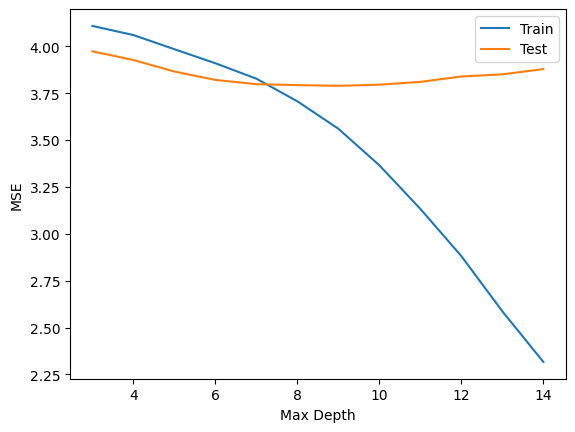

In [118]:
train_errors = []
test_errors = []

for max_depth in tqdm(max_depths):
    rf = RandomForestRegressor(max_depth=max_depth)
    rf.fit(X_train, y_train)
    train_errors.append(np.mean((rf.predict(X_train) - y_train) ** 2))
    test_errors.append(np.mean((rf.predict(X_test) - y_test) ** 2))

plt.plot(max_depths, train_errors, label='Train')
plt.plot(max_depths, test_errors, label='Test')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.legend()

In [119]:
max_depths[np.argmin(test_errors)]

np.int64(9)

In [120]:
model = RandomForestRegressor(n_estimators=100, max_depth=max_depths[np.argmin(test_errors)])

In [121]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=np.int64(9))

In [122]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'Train Error: {np.mean(np.abs(y_train - y_train_pred)):.3f}')
print(f'Test Error:  {np.mean(np.abs(y_test - y_test_pred)):.3f}')

Train Error: 1.384
Test Error:  1.414


In [123]:
N = len(data_properties)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[:N])
exp = explainer(X_test[:N])

GT:   sin(pow3(x1)) * ((<num> * x1) - (<num> / x2))
Pred: <num> * (x1 * sin(pow3(x1) + (<num> / x2)))


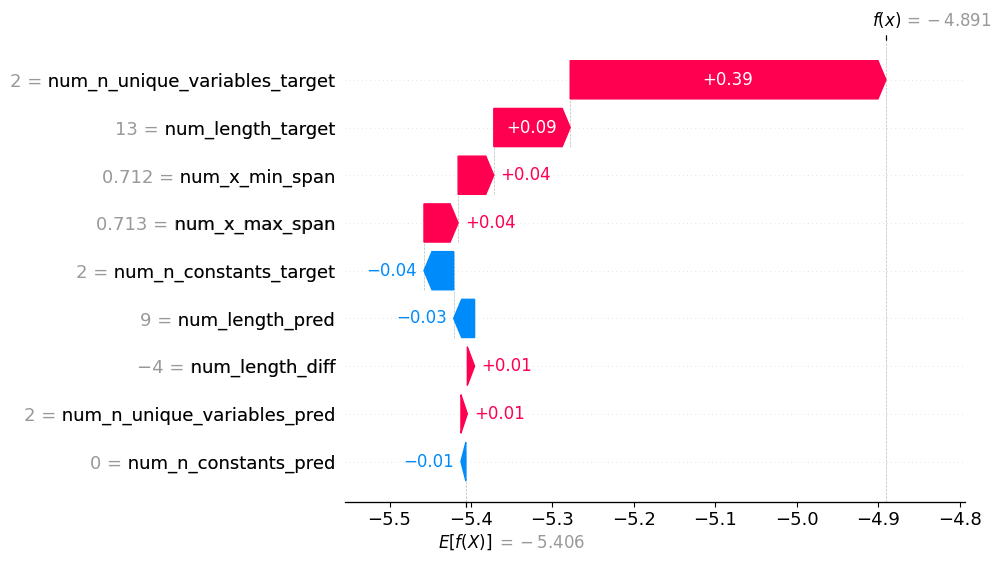

In [124]:
id = 20
id_in_test_set = X_test.index[id]
print(f'GT:   {space.prefix_to_infix(expressions_gt[id_in_test_set])}')
print(f'Pred: {space.prefix_to_infix(expressions_pred[id_in_test_set])}')
shap.waterfall_plot(exp[id])

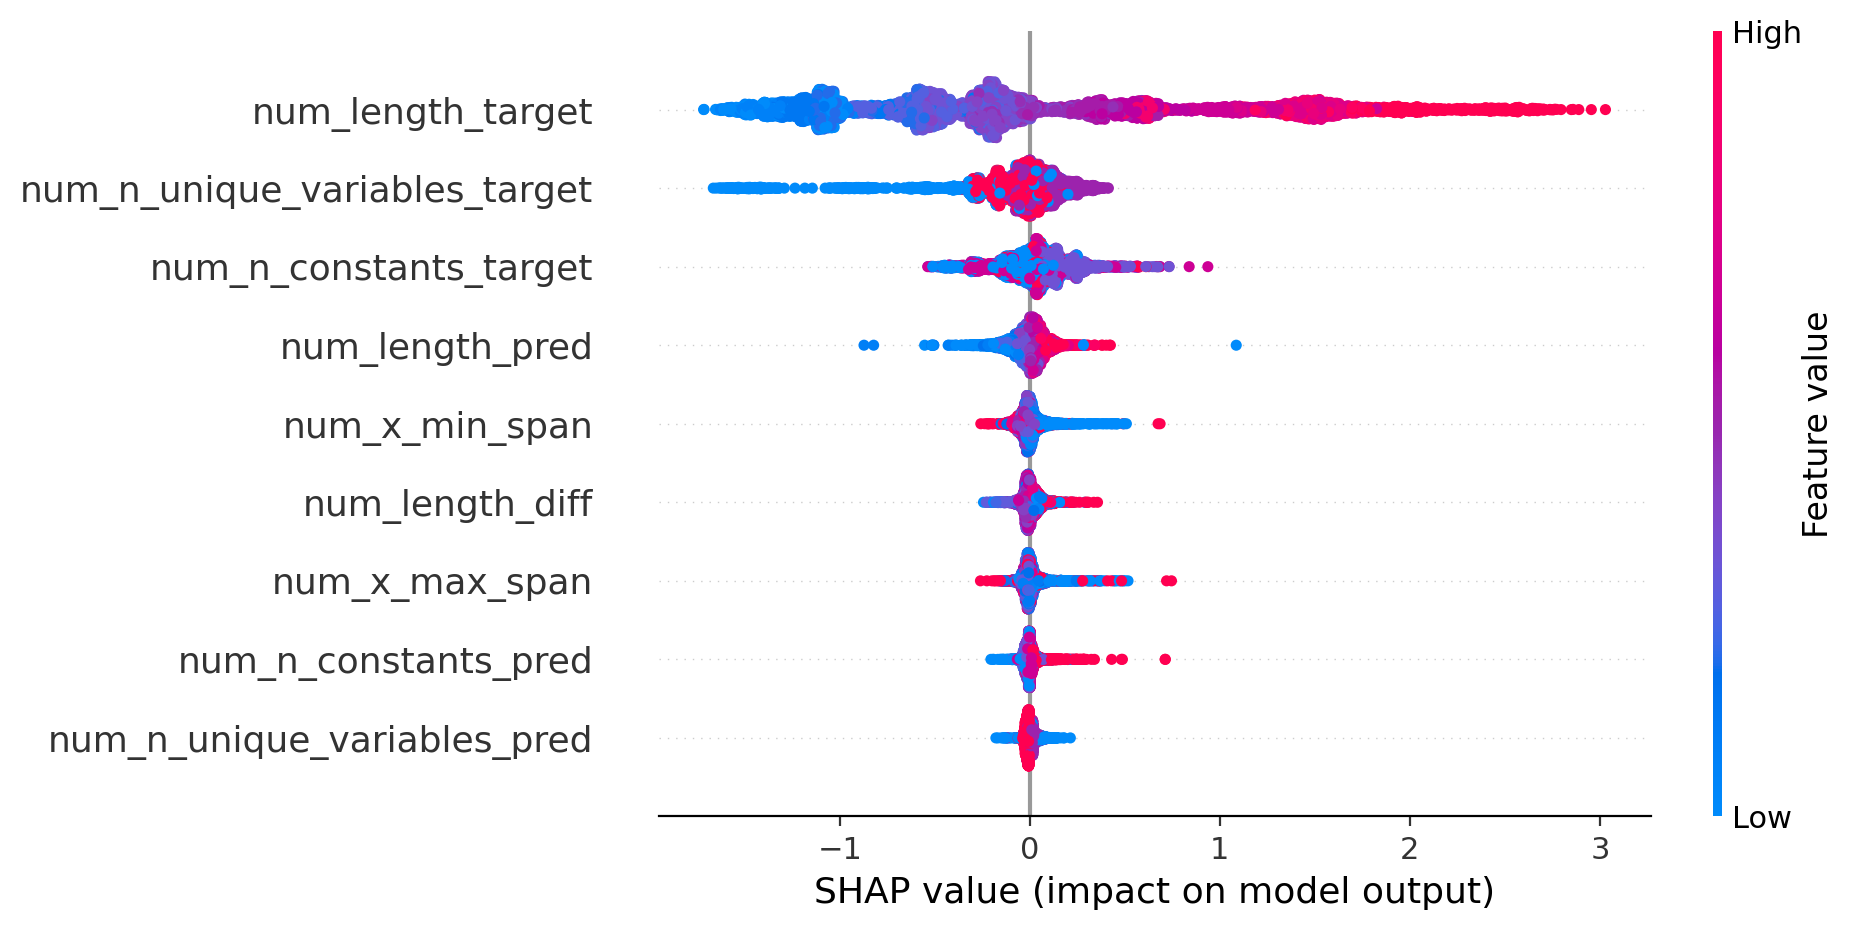

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)

shap.plots.beeswarm(exp)

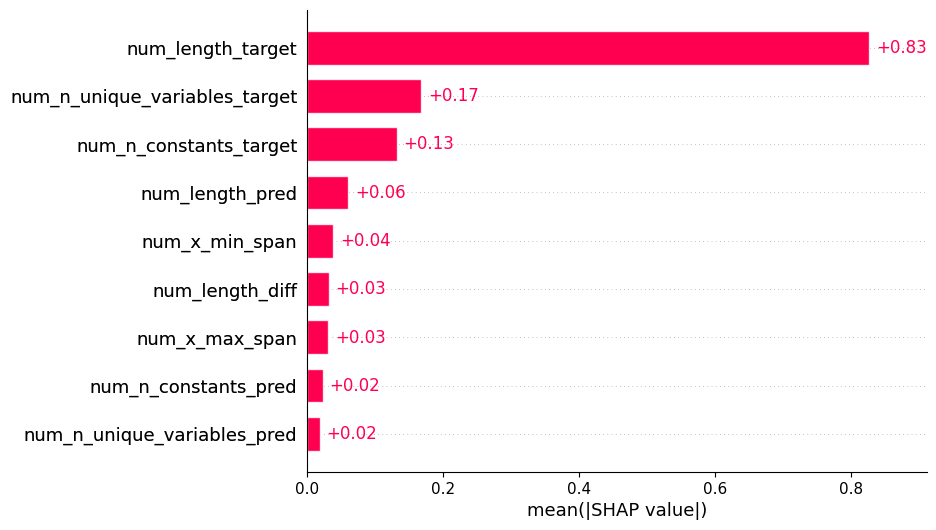

In [126]:
# Show which features have the most impact
shap.plots.bar(exp)

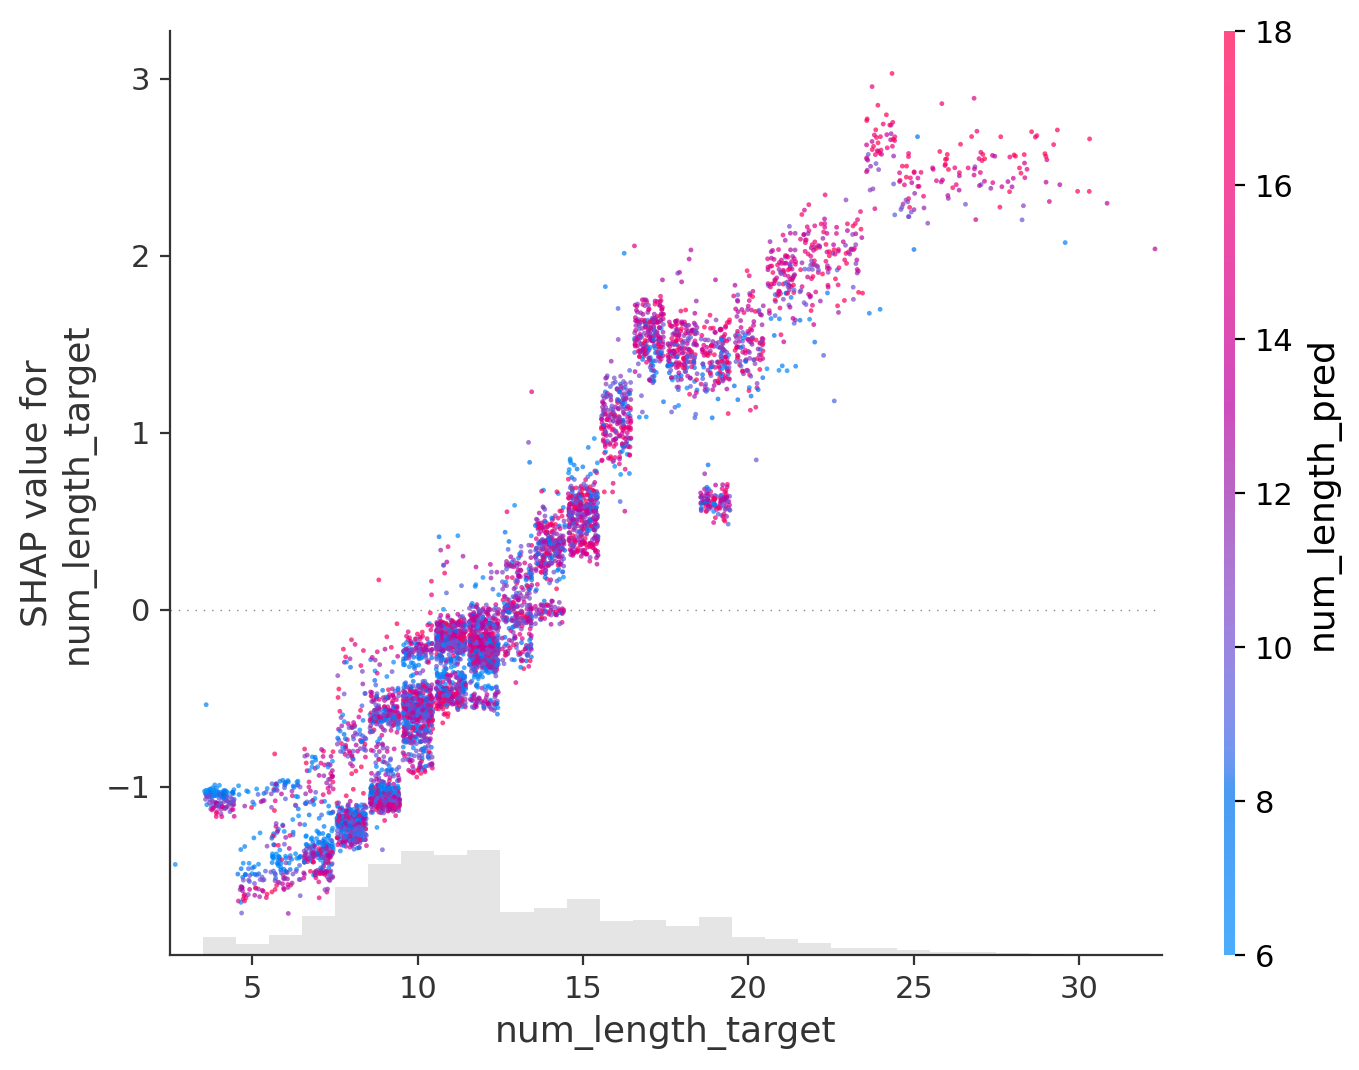

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)

shap.plots.scatter(exp[:, 0], color=exp[:, 5],  alpha=.7, dot_size=3, ax=ax, x_jitter=0.9)

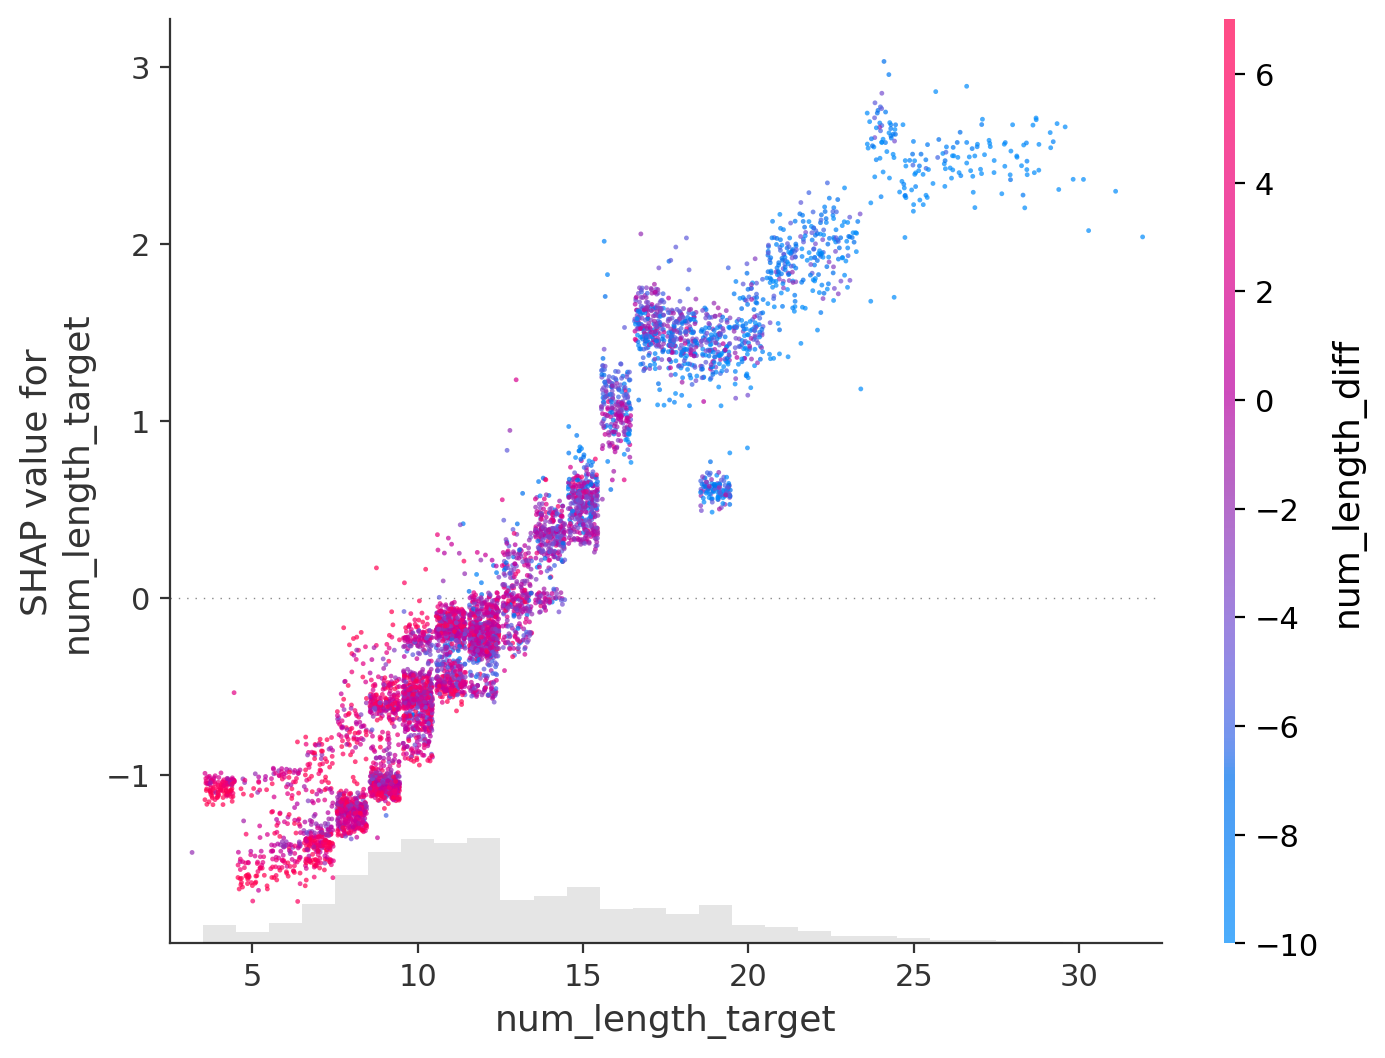

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)

# ax.annotate('more distinct', (0.05, 0.05), xycoords='axes fraction', ha='left', va='center', fontsize=10, color='k', zorder=10)
# ax.annotate('more similar', (0.95, 0.05), xycoords='axes fraction', ha='right', va='center', fontsize=10, color='k', zorder=10)
# ax.annotate('for shorter expressions,\nmore distinct embeddings\nhave a larger impact', (0.60, 0.85), xycoords='axes fraction', ha='center', va='center', fontsize=10, color='k', zorder=10)

shap.plots.scatter(exp[:, 0], color=exp[:, 8], alpha=.7, dot_size=3, ax=ax, x_jitter=0.9)

# Consider Training Data

In [129]:
from flash_ansr import FlashANSRDataset
from flash_ansr.eval.utils import bootstrapped_metric_ci

dataset_train = FlashANSRDataset.from_config(get_path('configs', 'v7.0', 'dataset_train.yaml'))

Compiling Skeletons: 100%|██████████| 4999/4999 [00:00<00:00, 27740.28it/s]


In [130]:
N_SAMPLES = 100_000

In [ ]:
data_raw = [d for d in dataset_train.iterate(size=N_SAMPLES, verbose=True)]

In [54]:
data = {k: [d[k] for d in data_raw] for k in data_raw[0].keys()}

In [55]:
data['skeletons'] = [[str(token) for token in d] for d in data['skeletons']]
data['expressions'] = [[str(token) for token in d] for d in data['expressions']]
data['lengths'] = np.array([len(s) for s in data['skeletons']])
data['n_support'] = np.array([len(s) for s in data['x_tensors']])
data['n_constants'] = np.array([len(constants) for constants in data['constants']])
data['n_variables'] = np.array([len([t for t in s if t in dataset_train.skeleton_pool.expression_space.variables]) for s in data['skeletons']])

In [169]:
expression_length_distribution = np.bincount(data['lengths'])
expression_length_distribution = expression_length_distribution / expression_length_distribution.sum()
expression_length_distribution = np.concatenate([expression_length_distribution, np.zeros(31 - len(expression_length_distribution))])

In [241]:
expression_length_distribution_theoretical = np.arange(1, 23)
expression_length_distribution_theoretical = expression_length_distribution_theoretical / expression_length_distribution_theoretical.sum()
expression_length_distribution_theoretical = np.concatenate([expression_length_distribution_theoretical, np.zeros(31 - len(expression_length_distribution_theoretical))])

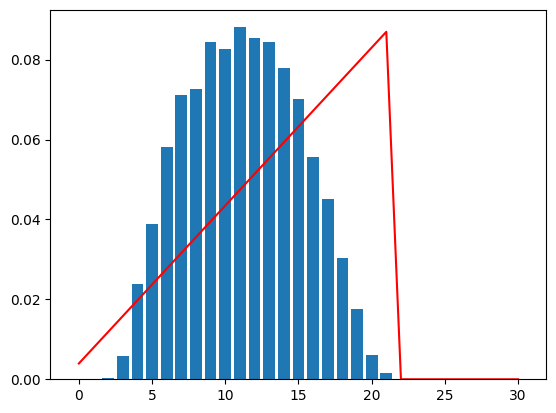

In [242]:
plt.bar(np.arange(len(expression_length_distribution)), expression_length_distribution)
plt.plot(np.arange(len(expression_length_distribution_theoretical)), expression_length_distribution_theoretical, color='red')

In [243]:
test_set = 'val'

In [244]:
test_lengths = np.array(results['v7.0'][test_set]['data']['length_target'])
test_log_fvu = np.log10(np.clip(results['v7.0'][test_set]['data']['fvu'], np.finfo(np.float64).eps, None))

In [245]:
median_log_fvu_per_length_bootstraps = np.array([bootstrapped_metric_ci(test_log_fvu[test_lengths == i], np.nanmedian) for i in range(1, 31)])

median_log_fvu_per_length_median = median_log_fvu_per_length_bootstraps[:, 0]
median_log_fvu_per_length_lower = median_log_fvu_per_length_bootstraps[:, 1]
median_log_fvu_per_length_upper = median_log_fvu_per_length_bootstraps[:, 2]

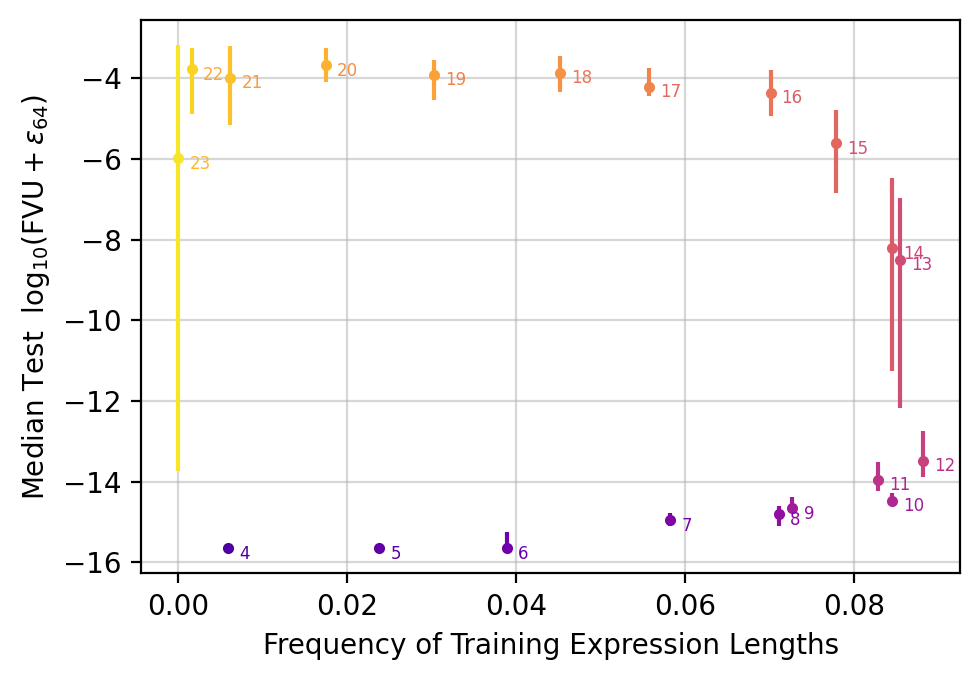

In [278]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), dpi=200)

for i, (l, l_theo, lower, mid, upper) in enumerate(zip(expression_length_distribution, expression_length_distribution_theoretical, median_log_fvu_per_length_lower, median_log_fvu_per_length_median, median_log_fvu_per_length_upper)):
    ax.errorbar(
        l,
        mid,
        yerr=[[mid - lower], [upper - mid]],
        color=plt.get_cmap('plasma')(i / max(test_lengths)),
        fmt='.');

    ax.annotate(f'{i + 1}', (l, mid), xytext=(4, -2), textcoords='offset points', fontsize=6, va='center', ha='left', color=plt.get_cmap('plasma')(i / (3 + max(test_lengths))))

ax.grid(alpha=0.5)
ax.set_xlabel('Frequency of Training Expression Lengths')
ax.set_ylabel('Median Test  $\\text{log}_{10}(\\text{FVU} + \\epsilon_{64})$')
# ax.legend()
fig.tight_layout()